# Project Name: Lyric Generator
Description:
Implementing a Deep Neural network using LSTMs to create a character based lyric generator

Details:
1. step size: 40
2. batch size: 128
3. Epochs: 100
4. Songs: 1000

### Importing Libraries

In [1]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Activation,LSTM,Dense,CuDNNLSTM
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
np.random.seed(10)

Using TensorFlow backend.


### Reading Input
Parameters: 10 songs

In [2]:
df=pd.read_csv('./songdata.csv')['text'][:1000]
data=np.array(df)

### Creating corpus(all the characters in all the songs concatenated)
1. Converting all the characters to lower

In [3]:
corpus=''
for ix in range(len(data)):
    corpus+=data[ix]
corpus = corpus.lower()

### Creating Vocabulary and char, index mappings

In [4]:
vocab=list(set(corpus))
char_ix={c:i for i,c in enumerate(vocab)}
ix_char={i:c for i,c in enumerate(vocab)}

### Model Parameters

In [5]:
BATCH_SIZE = 128
maxlen = 40 ##timesteps
epochs = 100

### Setting up the timesteps

In [6]:
vocab_size=len(vocab) ##Dimentions of each char
print(vocab_size)
print(vocab)

50
['b', '?', 'p', 'q', '-', 'w', 'u', 'z', '1', '"', 'h', '2', ',', "'", 'l', 'k', 't', '7', 'v', ')', '5', 'd', 'c', '4', 's', ':', 'e', 'x', 'm', '9', '0', '8', ']', 'g', '[', 'r', '3', 'i', 'f', 'n', 'y', ' ', '\n', '(', 'j', '.', '6', 'a', 'o', '!']


In [7]:
len(corpus)

1169216

### Creating the train and test datasets

In [8]:
sentences=[]
next_char=[]
for i in range(len(corpus)-maxlen-1):
    sentences.append(corpus[i:i+maxlen])
    next_char.append(corpus[i+maxlen])
split_count = int(0.8 * len(corpus))
sentences_test = sentences[split_count:]
next_char_test = next_char[split_count:]
sentences = sentences[:split_count]
next_char = next_char[:split_count]

In [9]:
def generator(sentence_list, next_word_list, batch_size):
    '''
    Generator function to generate the input/output data using
    generators concept(to avoid RAM overflow)
    '''
    index = 0
    while True:
        x = np.zeros((batch_size, maxlen, vocab_size), dtype=np.bool)
        y = np.zeros((batch_size, vocab_size), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index]):
                x[i, t, char_ix[w]] = 1
            y[i, char_ix[next_word_list[index]]] = 1

            index = index + 1
            if index == len(sentence_list):
                index = 0
        yield x, y

In [10]:
def create_model(timesteps, vocab_size):
    '''
    Creating the model
    '''
    model=Sequential()
    model.add(CuDNNLSTM(128,input_shape=(timesteps,vocab_size)))
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy')
    return model

In [11]:
model = create_model(maxlen, vocab_size)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               92160     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total params: 98,610
Trainable params: 98,610
Non-trainable params: 0
_________________________________________________________________


In [12]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    '''
    Callback function to write output to file after each epoch
    '''
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]

    for diversity in [1]:#[0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
        examples_file.write(' '.join(sentence))

        for i in range(50):
            x_pred = np.zeros((1, maxlen, vocab_size))
            for t, word in enumerate(sentence):
                x_pred[0, t,char_ix[word]] = 1

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char_pred = ix_char[next_index]

            sentence = sentence[1:]
#             print(sentence)
            sentence += next_char_pred

            examples_file.write(" "+next_char_pred)
        examples_file.write('\n')
    examples_file.write('='*80 + '\n')
#     examples_file.flush()

### Opening the output file

In [13]:
examples_file = open("output_data.txt", "w")

### Training the model

In [14]:
file_path = "./checkpoints/LSTM_LYRICS-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}" % (
    len(vocab),
    maxlen,
    10
)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True)

checkpoint_path = "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
callbacks_list = [print_callback]
history = model.fit_generator(generator(sentences, next_char, BATCH_SIZE),
    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
    epochs=epochs,
    validation_data=generator(sentences_test, next_char_test, BATCH_SIZE)
                    ,validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1,
                   callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
7308/7308 [==============================] - 71s 10ms/step - loss: 1.5997 - val_loss: 1.5720
Epoch 2/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.4158 - val_loss: 1.5156
Epoch 3/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3737 - val_loss: 1.4958
Epoch 4/100
7308/7308 [==============================] - 46s 6ms/step - loss: 1.3506 - val_loss: 1.4869
Epoch 5/100
7308/7308 [==============================] - 47s 6ms/step - loss: 1.3354 - val_loss: 1.4771
Epoch 6/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3244 - val_loss: 1.4735
Epoch 7/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3169 - val_loss: 1.4639
Epoch 8/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3105 - val_loss: 1.4638
Epoch 9/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3065 - val_loss: 1.4640
Epoch 10/100
73

/home/iwonttellyouthat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


7308/7308 [==============================] - 46s 6ms/step - loss: 1.3147 - val_loss: 1.4492
Epoch 20/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3609 - val_loss: 1.4663
Epoch 21/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3018 - val_loss: 1.4644
Epoch 22/100
7308/7308 [==============================] - 49s 7ms/step - loss: 1.2921 - val_loss: 1.4544
Epoch 23/100
7308/7308 [==============================] - 49s 7ms/step - loss: 1.3048 - val_loss: 1.4497
Epoch 24/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.2875 - val_loss: 1.4492
Epoch 25/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3258 - val_loss: 1.4508
Epoch 26/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.3122 - val_loss: 1.4530
Epoch 27/100
7308/7308 [==============================] - 48s 7ms/step - loss: 1.2900 - val_loss: 1.4494
Epoch 28/100
7308/7308 [==============================] - 49s 7ms/st

7308/7308 [==============================] - 47s 6ms/step - loss: 2.8934 - val_loss: 2.9649
Epoch 98/100
7308/7308 [==============================] - 46s 6ms/step - loss: 2.8939 - val_loss: 2.9614
Epoch 99/100
7308/7308 [==============================] - 48s 7ms/step - loss: 2.8909 - val_loss: 2.9585
Epoch 100/100
7308/7308 [==============================] - 48s 7ms/step - loss: 2.8922 - val_loss: 2.9617


### Closing the output file

In [15]:
examples_file.close()

### Plotting Train Loss curve

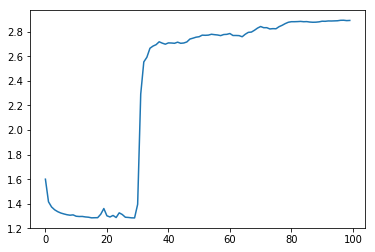

In [16]:
plt.plot(history.history['loss'])

### Plotting Validation Loss curve

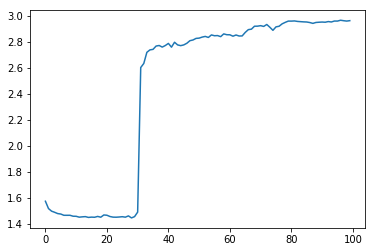

In [17]:
plt.plot(history.history['val_loss'])

### Saving the model to disk

In [18]:
model.save('keras_model.hdf5')
#loaded_model = keras.models.load_model('keras_model.hdf5')

In [19]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(history.history['val_loss'])
fig.savefig('./Train_loss.png')   # save the figure to file
plt.close(fig)    # close the figure

In [20]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(history.history['loss'])
fig.savefig('./Validation_loss.png')   # save the figure to file
plt.close(fig)    # close the figure

### Loading the model

In [21]:
#loaded_model = keras.models.load_model('keras_model.hdf5')

In [22]:
def sample(preds, temperature=1.0):
    '''
    Function to sample a character from the a given
    list of probs
    '''
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

### Testing the model

In [23]:
# txt = corpus
# start_index = 230

generated = ''
actual = ''
# sent=txt[start_index:start_index+maxlen]
sent = sentences_test[0]
generated += sent
actual += sent
print("Input - ",generated)
gen = generated
for i in range(100):
    x_sample=generated[i:i+maxlen]
    x = np.zeros((1,maxlen,vocab_size))
    for j in range(maxlen):
        x[0,j,char_ix[x_sample[j]]] = 1
    probs = model.predict(x)
    probs = np.reshape(probs,probs.shape[1])
    ix = np.argmax(probs)
#     ix=np.random.choice(range(vocab_size),p=probs.ravel())
    generated += ix_char[ix]
    actual += next_char_test[i]
# for i in range(100):
#     x_sample=gen[i:i+maxlen]
#     x=np.zeros((1,maxlen,vocab_size))
#     for j in range(maxlen):
#         x[0,j,char_ix[x_sample[j]]]=1
#     probs=loaded_model.predict(x)[0]
#     ix = np.argmax(probs)
# #     ix=np.random.choice(range(vocab_size),p=probs.ravel())
#     gen+=ix_char[ix]
# # print("--------------")

Input -    
you got yourself a place and i got mi


In [24]:
print("Generated - ")
print(generated)
print()
print("Actual -")
print(actual)

Generated - 
  
you got yourself a place and i got mi              
   
      
  

     
          a  
        a            
     
     n   
  
     
e  

Actual -
  
you got yourself a place and i got mine  
we been here waitin' since the clock struck nine  
down in the unemployment line  
now every da


### Credits